In [36]:
import dash
from dash import Dash, html, dash_table, dcc, callback, Output, Input, State
import pandas as pd
import plotly
import dash
import plotly.express as px
import copy
import base64
import io
import numpy as np
import itertools
import mlflow
import shap
import pickle
from mlflow.sklearn import load_model


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [37]:
# Pour générer le fichier requirement 
#pip freeze > requirements.txt

In [38]:
libraries = {
    "Pandas" : pd,
    "Plotly" : plotly,
    "Dash" : dash,
    "numpy" : np,
    "mlflow" : mlflow,
    "shap" : shap
}

# On affiche les différentes versions des librairies utilisées
for lib_name, lib in libraries.items():
    print(f"{lib_name} Version : {lib.__version__}")

Pandas Version : 1.5.3
Plotly Version : 5.9.0
Dash Version : 2.12.1
numpy Version : 1.23.5
mlflow Version : 2.6.0
shap Version : 0.42.1


In [95]:
# On load les données
data = pd.read_csv("concatenate_files.csv")

In [96]:
data["ANNEES_AGE"] = (abs(data.DAYS_BIRTH) / 365.25)
data["ANNEES_LAST_PHONE_CHANGE"] = round((abs(data.DAYS_LAST_PHONE_CHANGE) / 365.25), 2)

# On élimine les anciennes variables
data.drop(["DAYS_BIRTH", "DAYS_LAST_PHONE_CHANGE"], axis = 1, inplace = True)

In [97]:
infinity_indices = np.where(np.isinf(data))
for row_ind, col_ind in zip(*infinity_indices):
    data.iloc[row_ind, col_ind] = data.iloc[:,col_ind].median()

In [41]:
# On load le modèle 
model = load_model("banking_model_20230901135647")

In [8]:
proba_threshold = 0.42

In [11]:
data_dashboard = pd.read_csv("dash_file.csv")

In [26]:
file_df = None

In [265]:
# on charge l'objet explainer du modèle
with open('explainer_model.pkl', 'rb') as explainer_file:
    explainer_model = pickle.load(explainer_file)
# on charge les valeurs du modèle
feature_importance = pd.read_csv("shap_values_model.csv") 

In [349]:
def preparation_file(df, model):
    
    # On récupère les features du modèle
    features = model.named_steps["select_columns"].columns
    
    return  df[features]

In [350]:
prepared_data = preparation_file(data, model)

In [382]:
def scoring_pret(df, threshold):
    
    # On calcul un score selon si le client a obtenu un prêt ou pas
    # Ce score donne une autre appréciation des probabilités, plus parlant pour un consommateur

    df.loc[df.prediction_pret == "Pret", "score"] = ((1 - threshold) - df["proba_pred_non_pret"]) / (1 - threshold)
    df.loc[df.prediction_pret == "Non pret", "score"] = ((1 - threshold) - df["proba_pred_pret"]) / (1 - threshold) * - 1
    df.loc[:, "score"] = round(df.loc[:, "score"], 2)
    
    lettres = ['a', 'b', 'c', 'd', 'e', 'f']
    signes = ['++', '+', '-', '--']

    # On génére 2 dictionnaires
    bon_clients = {}
    mauvais_clients = {}

    point_decr = (100 / ((len(lettres) * len(signes)) / 2)) / 100

    point = 1
    for l, s in itertools.product(lettres[:3], signes):
        key = l + s
        bon_clients[key] = round(point, 2)
        point -= point_decr
    
    point = 0
    for l, s in itertools.product(lettres[3:], signes):
        key = l + s
        mauvais_clients[key] = round(point, 2)*-1
        point += point_decr

    condition1 = df.prediction_pret == "Pret"
    condition2 = df.prediction_pret == "Non pret"

    for keys, items in bon_clients.items():
        df.loc[(condition1) & (df.score <= items), "score_note"] = keys

    for keys, items in mauvais_clients.items():
        df.loc[(condition2) & (df.score <= items), "score_note"] = keys


    df.loc[:, "score"] = round(df.loc[:, "score"]*100, 2)
    
    return df

In [421]:
def application_model(df, model, threshold):
    
    result_df = copy.deepcopy(df)
    
    # On prédit les probabilité selon le modèle
    # Prédiction d'avoir un prêt
    result_df["proba_pred_pret"] = model.predict_proba(df)[:, 0]
    # Prédiction de ne pas avoir un prêt
    result_df["proba_pred_non_pret"] = 1 - result_df["proba_pred_pret"]
    #model.predict_proba(data)[:, 1]
    
    # Résultat selon le threshold du modèle établit. 
    # Si au dessus, la valeur = 1, ce qui correspond à la non obtention d'un prêt

    result_df["prediction"] = np.where(result_df["proba_pred_non_pret"] >= threshold, 1, 0)
    #result_df["prediction"].apply(lambda x: "Pret" if x == 0 else "Non pret")
    #(model.predict_proba(df)[:, 1] >= (threshold)).astype(int)
    
    result_df["prediction_pret"] = np.where(result_df["prediction"] == 1, "Non pret", "Pret")
    #result_df["prediction"].apply(lambda x: "Pret" if x == 0 else "Non pret")
    
    result_df = scoring_pret(result_df, threshold)
    
    return result_df

In [422]:
# On prépare les données selon le modèle
prepared_data = application_model(prepared_data, model, proba_threshold)

In [423]:
def feature_importance_client(df, model, explainer_model): 
    
    features = model.named_steps["select_columns"].columns
    
    x_train_preprocessed = model[:-1].transform(df[features])
    
    selected_cols = df[features].columns[model.named_steps["feature_selection"].get_support()]
    
    x_train_preprocessed = pd.DataFrame(x_train_preprocessed, columns = selected_cols)
    
    shap_values = explainer_model(x_train_preprocessed)
    
    df_sk_shape = pd.DataFrame({'SK_ID_CURR': df["SK_ID_CURR"].values, 'value_total': shap_values.values.sum(axis=1)})

    df_feat_shape = pd.DataFrame(shap_values.values, columns = selected_cols)

    df_shape_score = pd.concat([df_sk_shape, df_feat_shape], axis = 1)
    
    return df_shape_score

In [425]:
# On calcule les scores obtenus par chaque variable selon le modèle
df_client_score = feature_importance_client(prepared_data, model, explainer_model)

In [430]:
list_client = [100002,100003]

In [721]:
import plotly.subplots as sp

In [805]:
def figure_feature_client_dash(df, list_client, df_client, nb_variable = 10, color_point = "plotly", size = 18):
    
    # on ajuste la couleur des barres du graphique
    if color_point == "colorblind":
        color_bar = "#648FFF"
        color_bar_selected = "#FFB000"
    else :
        color_bar = "blue"
        color_bar_selected = "red"
    
    # On récupère la liste de client d'intérêt
    mask = return_dataframe_client(df, list_client)
     
    figure_height = (mask.shape[0] * size)
    
    for i, client in mask.iterrows():
        
        mask_client = df_client.iloc[i,:]

        figure_height = 200 + (len(client[2:]) * size+1)
        
        # on trie les variables selon leur influence sur le résultat et on ne garde que les nb_variables premières valeurs
        index = abs(client[2:]).sort_values(ascending=True)[-nb_variable:].index
        
        # Pour afficher les valeurs sur le graphiques
        texte_liste = round(client[index], 2).astype(str).values
        # Permet de standardiser la taille du nom des variables
        texte_variable = index.str[:20]
        texte_valeur = mask_client[index].values
        # on format
        texte_valeur = [round(x) if abs(x) > 5 else round(x, 2) for x in texte_valeur]
              
        # On ajoute la valeur de la variable au nom de la variable
        combined_texte = [f"{x} ({y})" for x, y in zip(texte_variable, texte_valeur)]
        
        # Create the bar chart with labels
        figure_var = px.bar(client[index], 
                        y=index, 
                        x=round(client[index], 2).values,
                        text=texte_liste,  
                        height=figure_height)
        
        #figure.update_traces(textposition='auto', textfont_size=size)
        
        # on met une couleur selon si la variable a une influence positive ou négative sur le score.
        colors = [color_bar_selected if client[col] <= 0 else color_bar for col in client[index].index]
        figure_var.update_traces(marker_color=colors)
        
        shape_global = {'nom': ["Résultat global"], 'valeur': round(client[1], 2)}
        figure_global = px.bar(shape_global,
                        x='valeur',
                        text='valeur',
                        height=200)
        colors = [color_bar_selected if shape_global["valeur"] <= 0 else color_bar]
        figure_global.update_traces(marker_color=colors)
        
        # On crée un subplot de 2 lignes, avec une différence de taille entre les 2 figures
        fig_general = sp.make_subplots(rows=2, cols=1, row_heights=[9, 1], shared_xaxes=True,
                              subplot_titles=("Valeurs par variable","Valeur globale"),
                              vertical_spacing=0.1)

        # On ajoute la première figure en haut
        for trace in figure_var.data:
            fig_general.add_trace(trace, row=1, col=1)

        # On ajoute la seconde en bas
        for trace in figure_global.data:
            fig_general.add_trace(trace, row=2, col=1)
            
        fig_general.update_yaxes(ticktext=combined_texte, tickvals=list(range(nb_variable)), row=1, col=1)
        fig_general.update_yaxes(ticktext=[shape_global["nom"]], tickvals=[0], row=2, col=1)
        fig_general.update_layout(height=figure_height)

        fig_general.update_layout(
            title=dict(
                text = (
                    f"{nb_variable} variable{'s' if nb_variable > 1 else ''} "
                    f"contribue{'nt' if nb_variable > 1 else ''} à expliquer "
                    "--à définir-- % du modèle"),
                font=dict(size=8+size, color="black"), x=0.5, xanchor='center'),
            
            font=dict(size=size, color="black"),
            xaxis=dict(title = "Importance relative de chaque variable"),
            yaxis=dict(title = "Variable(s) d'intérêt(s)",
                tickmode='array', tickvals=list(range(nb_variable)),  
                dtick=1, automargin=True)
        )
            
        fig_general.add_shape(type="line", x0=0, x1=0, y0=-0.5, y1=nb_variable-0.5,
                            line=dict(color="black", width=2), row=1, col=1)
        fig_general.add_shape(type="line", x0=0, x1=0, y0=-0.5, y1=0.5,
                            line=dict(color="black", width=2), row=2, col=1)
    return fig_general
        
def return_dataframe_client(df, list_client):
    return df.loc[df.SK_ID_CURR.isin(list_client)]


In [806]:
figure_feature_client_dash(df_client_score, list_client, return_dataframe_client(prepared_data, list_client))

In [ ]:
#def figure_feature_client_dash(df, feats, importance, size, variance_importance = 0.9, color_point = "plotly", list_client = None):
    ## 
    #    Fonction retournant un object de type figure
    #    On filtre les variables à afficher selon l'importance qu'ils ont sur le modèle (du plus important au moins)
    #    variance_importance = 0.5 : On affiche les variables qui ont 50 % du poids du modèle 
    #    variance_importance = 1 : On affiche l'ensemble des variables qui contribue au modèle
    ##
    
    
    # on ajuste la couleur des barres du graphique
    if color_point == "colorblind":
        color_bar = "#648FFF"
        color_bar_selected = "#FFB000"
    else :
        color_bar = "blue"
        color_bar_selected = "red"
        
    mask = feature_importance_threshold(df, feats, importance, variance_importance)
    
    mask.sort_values(importance, ascending = True, inplace = True)
    
    # Permet de standardiser la taille du nom des variables, selon la taille du texte
    mask["truncated"] = mask[feats].str[:(60 - size)]
    
    figure_height = 200 + (mask.shape[0] * (size+1))
    
    # On instancie un objet px.bar avec les features filtrées
    figure = px.bar(mask, 
                    y=feats, 
                    x=importance,
                    height=figure_height, 
                   )

        
    # Si on a une liste de features sélectionnées, on les met en avant
    if list_feat:
        colors = [color_bar_selected if f in list_feat else color_bar for f in mask[feats]]
        figure.update_traces(marker_color=colors)
    else : 
        figure.update_traces(marker_color=color_bar)
        
    figure.update_yaxes(ticktext=mask["truncated"], tickvals=list(range(len(mask["truncated"]))))
    figure.update_layout(
        title=dict(
            text = (
                    f"{mask.shape[0]} variable{'s' if mask.shape[0] > 1 else ''} "
                    f"contribue{'nt' if mask.shape[0] > 1 else ''} à expliquer "
                    f"{variance_importance * 100} % du modèle"
                ),
            font=dict(size=8+size, color="black"),
            x=0.5,  # Center the title horizontally
            xanchor='center'
        ),
        font=dict(size=size, color="black"),
        xaxis=dict(title = "Importance (valeur absolue)"),
        yaxis=dict(
            tickmode='array',  
            tickvals=list(range(mask.shape[0])),  
            dtick=1,  
            automargin=True)
    
    )
    # On retourne la figure
    return figure


In [67]:
shap.initjs()

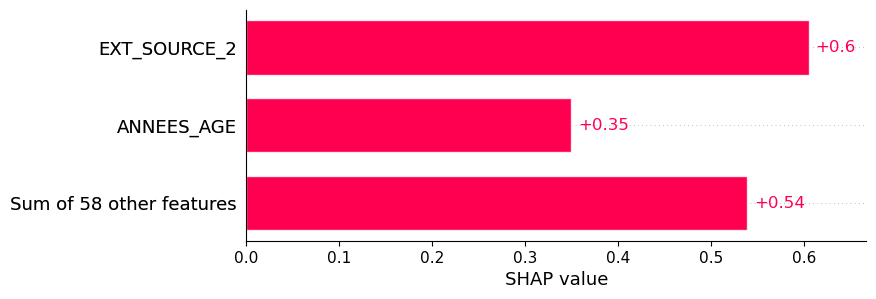

proba_pred_pret        0.276633
proba_pred_non_pret    0.723367
prediction                    1
prediction_pret        Non pret
score                     -52.0
score_note                   e-
Name: 0, dtype: object

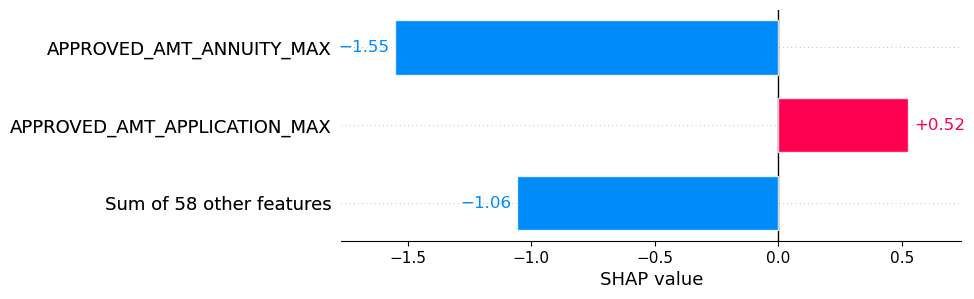

proba_pred_pret        0.931821
proba_pred_non_pret    0.068179
prediction                    0
prediction_pret            Pret
score                      88.0
score_note                   a+
Name: 1, dtype: object

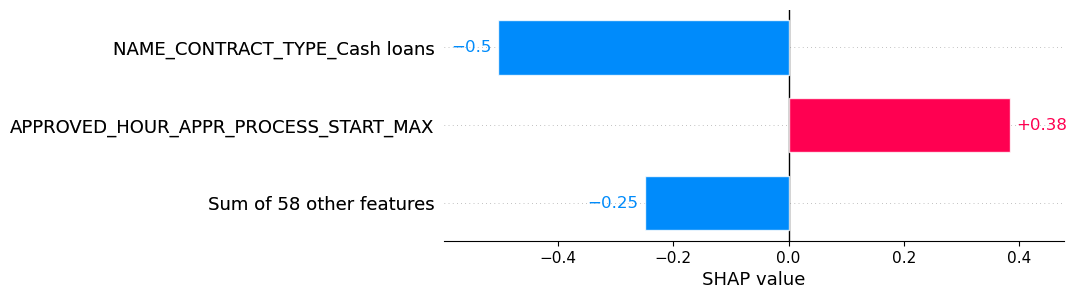

proba_pred_pret        0.710937
proba_pred_non_pret    0.289063
prediction                    0
prediction_pret            Pret
score                      50.0
score_note                   b-
Name: 2, dtype: object

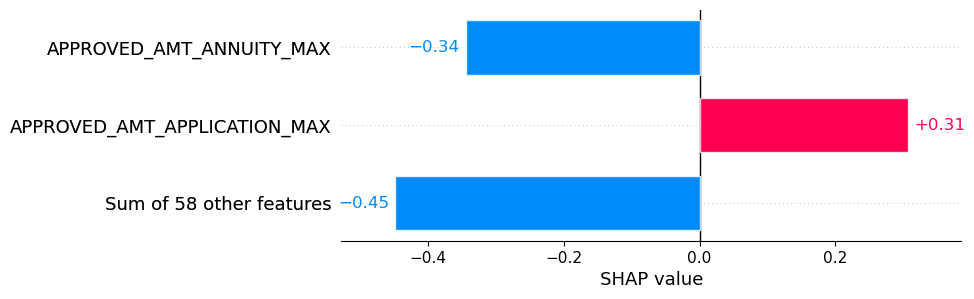

proba_pred_pret        0.734408
proba_pred_non_pret    0.265592
prediction                    0
prediction_pret            Pret
score                      54.0
score_note                   b+
Name: 3, dtype: object

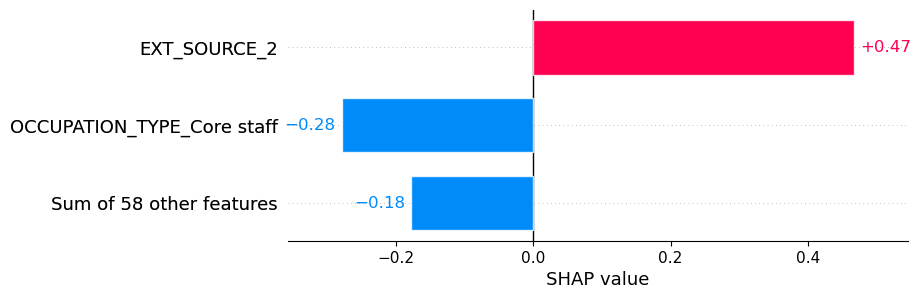

proba_pred_pret        0.627469
proba_pred_non_pret    0.372531
prediction                    0
prediction_pret            Pret
score                      36.0
score_note                  b--
Name: 4, dtype: object

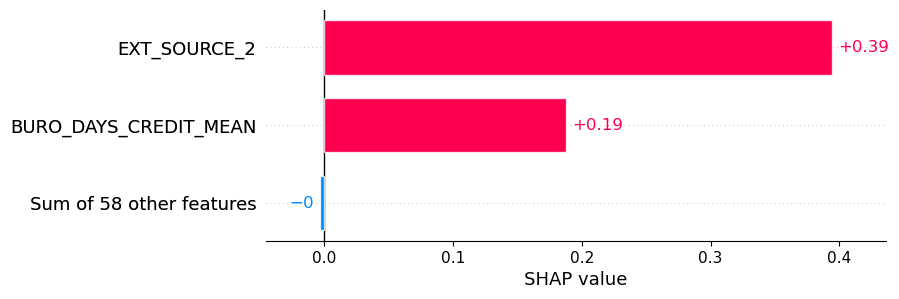

proba_pred_pret        0.488117
proba_pred_non_pret    0.511883
prediction                    1
prediction_pret        Non pret
score                     -16.0
score_note                   d+
Name: 5, dtype: object

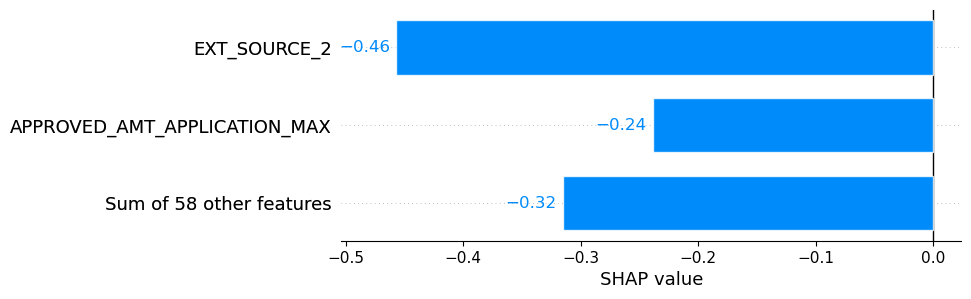

proba_pred_pret        0.823696
proba_pred_non_pret    0.176304
prediction                    0
prediction_pret            Pret
score                      70.0
score_note                  a--
Name: 6, dtype: object

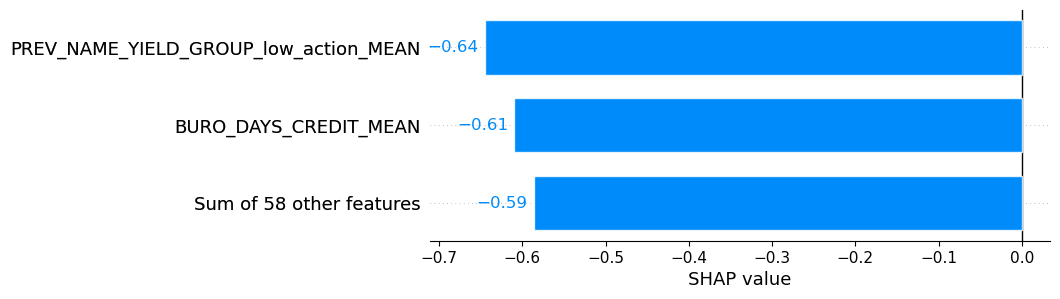

proba_pred_pret        0.914679
proba_pred_non_pret    0.085321
prediction                    0
prediction_pret            Pret
score                      85.0
score_note                   a+
Name: 7, dtype: object

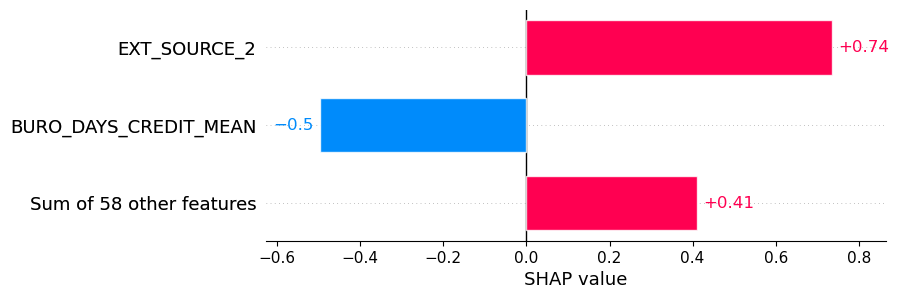

proba_pred_pret        0.470268
proba_pred_non_pret    0.529732
prediction                    1
prediction_pret        Non pret
score                     -19.0
score_note                   d-
Name: 8, dtype: object

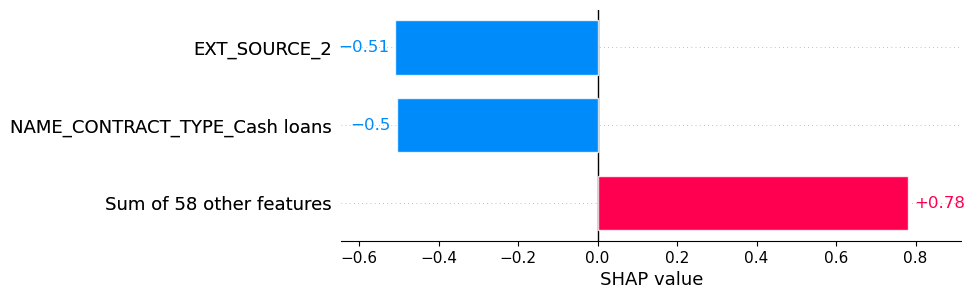

proba_pred_pret        0.682213
proba_pred_non_pret    0.317787
prediction                    0
prediction_pret            Pret
score                      45.0
score_note                   b-
Name: 9, dtype: object

In [392]:
for i in range(10):
    shap.plots.bar(shap_values[i], max_display = 3)
    display(prepared_data.iloc[i,100:])
    plt.show()

In [258]:
def coefficients_importance_by_shape(model, model_name, x_train, y_train, feature_names, model_type):
    ##
    #    Fonction permettant un affichage indépendant avec SHAP de l'importance des variables dans les modèles
    #    De façon local et global
    ##

    np.random.seed(42)
    random.seed(42)  
        
    # On sélectionnne un sous échantillonnage pour limiter les temps de calcul
    ech_indices = np.random.choice(x_train.shape[0], size = 500, replace=False)
    x_train_ech = x_train[ech_indices]
    
    if model_type == 0: 
        explainer = shap.LinearExplainer(model, x_train_ech)

    elif model_type == 1:
        explainer = shap.TreeExplainer(model, x_train_ech)

    elif model_type == 2:
        explainer = shap.KernelExplainer(model.predict_proba, x_train_ech)
        
    elif model_type == 3:
        explainer = shap.PermutationExplainer(model, x_train_ech)
        
    # check_additivity=False pour les TreeExplainer
    shap_values = explainer.shap_values(x_train_ech) if model_type != 1 else explainer.shap_values(x_train_ech, check_additivity=False)
    if model_type != 3:
        expected_values = explainer.expected_value
    
    if len(shap_values) == 2:
        shap_values = shap_values[1] 
        expected_values = expected_values[0]
        
    print("Utilisation de SHAP pour une explication indépendante des modèles")
    print("En quoi les variables contribue à un défaut de paiement :")
    
    # On récupère les meilleures features
    x_train_ech_top, shap_values_top, top_feature_names, feature_importances = top_shape_features(shap_values, x_train_ech, feature_names)
    
    # On affiche l'importance des features selon SHAP
    plot_feature_importance(feature_importances, feature_names, model_name)
    
    shap.summary_plot(shap_values_top, 
                      x_train_ech_top,
                      feature_names=[name[:20] for name in top_feature_names], 
                      max_display=20, show=False, plot_size=(10, 6))
    
    # On récupère les informations des objets figures
    fig, ax = plt.gcf(), plt.gca()

    ax.tick_params(labelsize=14)
    ax.set_xlabel("Valeurs de SHAP (impacts sur les sorties du modèle)", fontsize=16)
    ax.set_title("Importance des Features - Prédiction sur l'obtention d'un crédit bancaire", fontsize=20)
    
    #On met une limite, pour avoir un meilleur affichage
    #ax.set_xlim(-2, 2)
    
    # On récupère la barre de couleur
    cb_ax = fig.axes[1] 

    # On modifie les paramètres de la barre de couleur
    cb_ax.tick_params(labelsize=15)
    cb_ax.set_ylabel("Feature value", fontsize=20)
    
    plt.show()
    
    # On recherche les indices de chaque catégories
    ech_indices_cat0 = np.where((y_train.iloc[ech_indices] == 0))[0]
    ech_indices_cat1 = np.where((y_train.iloc[ech_indices] == 1))[0]

    # On choisit aléatoirement 3 de chaque catégories
    random_indices_cat0 = random.sample(list(ech_indices_cat0), 3)
    random_indices_cat1 = random.sample(list(ech_indices_cat1), 3)
    
    if model_type != 3:
        for i in range(2):
            category_indices = random_indices_cat0 if i == 0 else random_indices_cat1
        
        for j in range(3):
            shap.force_plot(expected_values, shap_values_top[category_indices[j]], top_feature_names, matplotlib=True)
            plt.show()

In [284]:
def feature_importance_threshold(df, feats, importance, variance_importance = 0.9):

    # On récupère le total
    variance_total = df[importance].sum()
    
    # Ce qui va nous permettre d'identifier les variables à afficher
    variance_threshold = variance_total * variance_importance
    
    # On trie
    df.sort_values(importance, ascending = False, inplace = True)
    
    # On mesure la somme continue de l'importance, en partant de la variable la plus importante
    cumsum = df[importance].cumsum()
    
    # On ne sélectionne que les features
    cols_num = [cols_num for cols_num, val in zip(cumsum.index, cumsum) if val <= variance_threshold]
    
    return df[df.index.isin(cols_num)]

def figure_feature_importance_dash(df, feats, importance, size, variance_importance = 0.9, color_point = "plotly", list_feat = None):
    ## 
    #    Fonction retournant un object de type figure
    #    On filtre les variables à afficher selon l'importance qu'ils ont sur le modèle (du plus important au moins)
    #    variance_importance = 0.5 : On affiche les variables qui ont 50 % du poids du modèle 
    #    variance_importance = 1 : On affiche l'ensemble des variables qui contribue au modèle
    ##
    
    
    # on ajuste la couleur des barres du graphique
    if color_point == "colorblind":
        color_bar = "#648FFF"
        color_bar_selected = "#FFB000"
    else :
        color_bar = "blue"
        color_bar_selected = "red"
        
    mask = feature_importance_threshold(df, feats, importance, variance_importance)
    
    mask.sort_values(importance, ascending = True, inplace = True)
    
    # Permet de standardiser la taille du nom des variables, selon la taille du texte
    mask["truncated"] = mask[feats].str[:(60 - size)]
    
    figure_height = 200 + (mask.shape[0] * (size+1))
    
    # On instancie un objet px.bar avec les features filtrées
    figure = px.bar(mask, 
                    y=feats, 
                    x=importance,
                    height=figure_height, 
                   )
        
    # Si on a une liste de features sélectionnées, on les met en avant
    if list_feat:
        colors = [color_bar_selected if f in list_feat else color_bar for f in mask[feats]]
        figure.update_traces(marker_color=colors)
    else : 
        figure.update_traces(marker_color=color_bar)
        
    figure.update_yaxes(ticktext=mask["truncated"], tickvals=list(range(len(mask["truncated"]))))
    figure.update_layout(
        title=dict(
            text = (
                    f"{mask.shape[0]} variable{'(s)' if mask.shape[0] > 1 else ''} "
                    f"contribue{'nt' if mask.shape[0] > 1 else ''} à expliquer "
                    f"{variance_importance * 100} % du modèle"
                ),
            font=dict(size=8+size, color="black"),
            x=0.5,  # Center the title horizontally
            xanchor='center'
        ),
        font=dict(size=size, color="black"),
        xaxis=dict(title = "Importance (valeur absolue)"),
        yaxis=dict(
            tickmode='array',  
            tickvals=list(range(mask.shape[0])),  
            dtick=1,  
            automargin=True)
    
    )
    # On retourne la figure
    return figure


In [285]:
##### Initialize the app - incorporate css
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = Dash(__name__, external_stylesheets=external_stylesheets)


# App layout
app.layout = html.Div([
    
    # Titre dashboard
    html.Div(className='row', children="Utilisation du modèle pour prédire l'obtention d'un prêt",
             style={'textAlign': 'center', 'color': 'black', 'fontSize': 30}),
    html.Hr(), # Ligne horizontale
    
    # Upload liste de clients et leur caractéristiques
    html.Div(className='row',
        style={'textAlign': 'center', 'color': 'black', 'fontSize': 24}, children=[
            html.Div(className='row', children = "Chargez votre fichier clients ou le fichier test.csv"),
            # Boutton pour upload données 
            dcc.Upload(id="upload-data",children=[
                html.Button("Upload un fichier .csv", style={'color': 'black'})], multiple=False),
            html.Div(className='row', children="ou"),
            # Boutton pour upload les données tests
            html.Button("Upload test.csv", id="test_file_button", n_clicks=0, style={'color': 'black'}),
    ]),   

    html.Hr(), # Ligne horizontale
    
        # Choix des clients
    html.Div(className='row', children=[
        html.Div(className='client-selection', children=[
                html.Div("Choix d'un client :",
                         style={'textAlign': 'left', 'color': 'black', 'fontSize': 18}),
                dcc.Dropdown(
                        value=None,
                        style={'textAlign': 'left', 'color': 'black', 'fontSize': 15},
                        placeholder="Sélection client(s)",
                        multi=True,
                        id='dropdown_client'
                ),
            ],
        ),
        # On affiche les 2 tableaux
        html.Div(id="table_client"),
        html.Div(className='row', children="Score de prédiction de l'obtention d'un prêt",
             style={'textAlign': 'center', 'color': 'black', 'fontSize': 30}),
        html.Div(id="table_prediction"),
        
            # Upload liste de clients et leur caractéristiques
        html.Div(className='row',
            style={'textAlign': 'center', 'color': 'black', 'fontSize': 24}, children=[
                html.Div(className='row', children = "Télécharger les fichiers de prédictions"),
                # Boutton pour download les résultats 
                html.Button("Result_prediction_all.csv", id="download-data_all-button", n_clicks = 0, style={'color': 'black'}),
                html.Button("Result_prediction_client.csv", id="download-data_client-button", n_clicks = 0, style={'color': 'black'}),
                dcc.Download(id="download-data"),
        ]),  
        
        html.Hr(), # Ligne horizontale
        # On affiche les différents graphs liés au résultat du modèle
        html.Div(className="figure_client", children=[
            # Option pour la taille des polices et des points
            html.Label("Taille police (axes et valeurs)"),
            dcc.Slider(id='font-size-slider', min=18, max=36, step=2, value=18,
                marks={i: str(i) for i in range(18, 37, 2)}),
            html.Label("Taille points (graphique)"),
            dcc.Slider(id='point-size-slider', min=4, max=16, step=2, value=8,
                marks={i: str(i) for i in range(4, 17, 2)}),
            # Option pour la palette de couleur
            html.Label("Sélectionnez une couleur de palette :"),
            dcc.RadioItems(id='color-palette-dropdown',
                style={'textAlign': 'left', 'color': 'black', 'fontSize': 15},
                options=[
                    {'label': 'Défaut', 'value': 'plotly'},
                    {'label': 'Daltonien', 'value': 'colorblind'}],
                value='plotly', inline=True),
            html.Div(className='row', children="Représentation des clients :",
             style={'textAlign': 'center', 'color': 'black', 'fontSize': 30}),
            html.Label("Sélectionnez une métrique de score :"),
            dcc.RadioItems(id='variables_graph', 
                style={'textAlign': 'left', 'color': 'black', 'fontSize': 15},
                options=[
                    {'label': 'Score', 'value': 'score'},
                    {'label': 'Proba_pred_pret', 'value': 'proba_pred_pret'},
                    {'label': 'Score_note', 'value': 'score_note'}],
                value='score', inline=True),
            dcc.Graph(id="graph_pred", style={'height': '600px', 'width': '100%', 'float': 'left'}),
            html.Label("Importances des variables pour le modèle (défaut = 0.9)"),
            dcc.Slider(id='feature-importance-slider', min=0, max=1, step=0.05, value=0.9,
                marks={i: str(round(i, 2)) for i in np.arange(0, 1.01, 0.05)}),
            dcc.Graph(id="graph_model", style={'width': '100%', 'float': 'left'}),
            #dcc.Graph(id="graph_client", style={'height': '600px', 'width': '50%', 'float': 'right'}),
            
        ]),
        # Choix des variables à représenter
        html.Div(className='variable-selection', 
            children=[
                html.Div("Afficher la distribution des variables définissant les clients",
                         style={'textAlign': 'center', 'color': 'black', 'fontSize': 18}),
                dcc.RadioItems(id='dropdown_fig_type', 
                    style={'textAlign': 'left', 'color': 'black', 'fontSize': 15},
                    options=[
                        {'label': 'Strip', 'value': 'strip'},
                        {'label': 'Boxplot', 'value': 'boxplot'}],
                    value='strip', inline=True),
                dcc.Dropdown(
                        value=None,
                        style={'textAlign': 'left', 'color': 'black', 'fontSize': 15},
                        placeholder="Sélection variable(s) (2 maximum)",
                        multi=True,
                        id='dropdown_variable'
                ),
                
                dcc.Graph(id="graph_variables", style={'height': '600px', 'width': '100%', 'float': 'left'}),
                
            ],
        ),
    ]),  
])


@app.callback(
    Output(component_id="table_client", component_property="children"),
    Output(component_id="table_prediction", component_property="children"),
    Output(component_id="graph_pred", component_property="figure"),
    Output(component_id="dropdown_variable", component_property="options"),
    Output(component_id="dropdown_client", component_property="options"),
    Output(component_id="dropdown_fig_type", component_property="options"),
    Output(component_id="dropdown_fig_type", component_property="value"),
    Output(component_id="graph_variables", component_property="figure"),
    Output(component_id="graph_model", component_property="figure"),
    Output(component_id="test_file_button", component_property="n_clicks"),
    Output(component_id="upload-data", component_property="contents"),
    Output(component_id="download-data", component_property="data"),
    Output(component_id="download-data_all-button", component_property="n_clicks"),
    Output(component_id="download-data_client-button", component_property="n_clicks"),
    
    Input(component_id="test_file_button", component_property="n_clicks"),
    Input(component_id="dropdown_client", component_property="value"),
    Input(component_id="variables_graph", component_property="value"),
    Input(component_id="dropdown_variable", component_property="value"),
    Input(component_id="upload-data", component_property="contents"),    
    Input(component_id="font-size-slider", component_property="value"), 
    Input(component_id="point-size-slider", component_property="value"),
    Input(component_id="color-palette-dropdown", component_property="value"),
    Input(component_id="dropdown_fig_type", component_property="value"),
    Input(component_id="feature-importance-slider", component_property="value"),
    Input(component_id="download-data_all-button", component_property="n_clicks"),
    Input(component_id="download-data_client-button", component_property="n_clicks"),
    
    
)



def update_table_and_button(n_clicks_file, selected_client, scoring_choisie, selected_variable, content, font_size, point_size, color_point, selected_affichage, variance_importance, n_clicks_dl_file_all, n_clicks_dl_file_clients):
    
    # On défini des couleurs selon la condition
    if color_point == "plotly" :
        color_discrete_map = {"Pret": "blue", "Non pret": "red"}
    
    #Développé par IBM, source : https://davidmathlogic.com/colorblind/)
    elif color_point == "colorblind" :
        color_discrete_map = {"Pret": '#648FFF', "Non pret": '#FFB000'}
    
    global file_df
    # On charge le fichier 
    if content is not None: 
        content_type, content_string = content.split(",")
        decoded = base64.b64decode(content_string)
        file_df = pd.read_csv(io.StringIO(decoded.decode('utf-8')))
        # On remet la valeur par défaut pour permettre de nouveaux téléchargements
        content = None
     
    # On charge le fichier test.csv
    if n_clicks_file == 1:
        file_df = pd.read_csv("test.csv")
        n_clicks_file = 0
        
    # Par défaut, si aucun fichier de chargé
    if file_df is None :
        table1, table2 = dash_table.DataTable(), dash_table.DataTable()
        figure_score, figure_variables, figure_feat_imp = px.scatter(), px.scatter(), px.bar()
        option_drop_var, option_drop_clients, option_drop_var_graph = [], [], []
        selected_affichage = None
        n_clicks_dl_file_all, n_clicks_dl_file_clients = 0, 0
        return table1, table2, figure_score, option_drop_var, option_drop_clients, option_drop_var_graph, selected_affichage, figure_variables, figure_feat_imp, n_clicks_file, content, None, n_clicks_dl_file_all, n_clicks_dl_file_clients
    
    elif file_df is not None :
        # On met à jour la liste de dropdown
        # La liste de variable est dépendante de la liste de feature importance
        
        feat_imp_threshold = feature_importance_threshold(feature_importance, "Features", "Importance", variance_importance).Features.values
        option_drop_var=[{'label': str(var), 'value': var} for var in [col for col in feat_imp_threshold]]
        #option_drop_var=[{'label': str(var), 'value': var} for var in [col for col in file_df.iloc[:, 1:100].columns]]
        option_drop_clients=[{'label': str(client), 'value': client} for client in file_df['SK_ID_CURR']]
        cols = [0] + list(range(-6, 0))

        if selected_client == []:
            selected_client = None

        if (type(selected_client) != list) & (selected_client is not None):
            selected_client = [selected_client]

        if selected_client is None :
            table1 = dash_table.DataTable(
                data=file_df.iloc[:, :100].to_dict('records'),
                page_size=10,
                style_table={'overflowX': 'auto'}
            )
            table2 = dash_table.DataTable(
                data=file_df.iloc[:, cols].to_dict('records'),
                page_size=10,
                style_table={'overflowX': 'auto'}
            )
        else :
            filtered_df = file_df[file_df['SK_ID_CURR'].isin(selected_client)]
            table1 = dash_table.DataTable(
                data=filtered_df.iloc[:, :100].to_dict('records'),
                page_size=10,
                style_table={'overflowX': 'auto'}
            )
            table2 = dash_table.DataTable(
                data=filtered_df.iloc[:, cols].to_dict('records'),
                page_size=10,
                style_table={'overflowX': 'auto'}
            )
        if scoring_choisie == "score" :
            threshold = 0
            textH = threshold + 5
            textB = threshold - 5

        elif scoring_choisie == "proba_pred_pret":
            threshold = 1 - proba_threshold
            textH = threshold + 0.05
            textB = threshold - 0.05
            
        if scoring_choisie in ["score", "proba_pred_pret"]:
            figure_score = px.strip(file_df, y=scoring_choisie,
                        # On fait figurer le nom des clients et leur note
                        hover_data=["SK_ID_CURR", "score_note"],  
                        # On établit la coloration selon la condition de prêt 
                        color=file_df["prediction_pret"],  
                        color_discrete_map=color_discrete_map
                        # on actualise les valeurs de l'axe des x
                        ).update_xaxes(range=[-0.5, 0.5], tickvals=[0]  

                        # On ajoute une ligne horizontale
                        ).add_shape(type="line", x0=-1, x1=1, y0=threshold, y1=threshold,
                            line=dict(color="red", width=1)

                        # On ajoute un texte au dessus de la ligne
                        ).add_annotation(text="Threshold", x=-0.4, y=textH, showarrow=False,
                            font=dict(color="red", size=20)

                        # On ajoute un texte au dessus de la ligne              
                        ).add_annotation(text="Prêt", x=0.4, y=textH, showarrow=False,
                            font=dict(color="black", size=20)

                        # On ajoute un texte en dessous de la ligne
                        ).add_annotation(text="Non Prêt", x=0.4, y=textB, showarrow=False,
                            font=dict(color="black", size=20)

                        # On regroupe tout sur un seul tick
                        ).update_traces(offsetgroup=0.5)
            figure_score.update_traces(marker = dict(size=point_size))
            
        else : 
            nb_pret = file_df[file_df.prediction_pret == 'Pret'].shape[0]
            nb_non_pret = file_df[file_df.prediction_pret == 'Non pret'].shape[0]

            figure_score = px.histogram(file_df.sort_values("score_note"), x = "score_note",
                        color=file_df.sort_values("score_note")["prediction_pret"],  
                        color_discrete_map=color_discrete_map                       
                            # On ajoute un texte au dessus de la ligne              
                        ).add_annotation(text=f"Prêt (n={nb_pret})", x=3, y=15, showarrow=False,
                            font=dict(color="black", size=20)

                        # On ajoute un texte en dessous de la ligne
                        ).add_annotation(text=f"Non prêt (n={nb_non_pret})", x=13, y=15, showarrow=False,
                            font=dict(color="black", size=20))

            figure_score.update_xaxes(title=dict(
                        text = "Distribution des clients selont leur score note",
                        font=dict(size=20, color="black"),
                    ))
            figure_score.update_yaxes(title=dict(
                        text = "Comptage (nombre de client(s))",
                        font=dict(size=20, color="black"),
                    ))
        
        figure_score.update_layout(font=dict(size=font_size, color="black"))
        
        # On revient à la condition initiale
        selected_variable = None if selected_variable == [] else selected_variable

        # Si aucune variable n'est sélectionnée, nous n'affichons rien
        if selected_variable == None:
            figure_variables = px.scatter()
            option_drop_var_graph = []
            selected_affichage = None

        # Si une ou deux variables sont sélectionnées, on affiche soit un strip, soit un scatterplot
        elif (type(selected_variable) == list) :
            if len(selected_variable) == 1 :
                
                # On met à jour les options d'affichages pour une variable
                option_drop_var_graph=[
                        {'label': 'Strip', 'value': 'strip'},
                        {'label': 'Boxplot', 'value': 'boxplot'}]
                if(selected_affichage not in ["strip", "boxplot"]):
                    selected_affichage = "strip"
                
                # Type d'affichage
                if selected_affichage == "strip":
                    figure_variables = px.strip(file_df, y=selected_variable[0],
                        # On fait figurer le nom des clients et leur note
                        hover_data=["SK_ID_CURR", "score_note"],  
                        # On établit la coloration selon la condition de prêt 
                        color=file_df["prediction_pret"],  
                        color_discrete_map=color_discrete_map
                        # On regroupe tout sur un seul tick
                        ).update_traces(offsetgroup=0.5)
                    
                elif selected_affichage == "boxplot":
                    figure_variables = px.box(file_df, y=selected_variable[0],
                        # On fait figurer le nom des clients et leur note
                        hover_data=["SK_ID_CURR", "score_note"],  
                        # On établit la coloration selon la condition de prêt 
                        color=file_df["prediction_pret"],  
                        color_discrete_map=color_discrete_map
                        )
            else :
                
                # On met à jour les options d'affichages pour deux variables
                option_drop_var_graph=[
                        {'label': 'Scatterplot', 'value': 'scatter'},
                        {'label': 'Densité', 'value': 'density'}]
                if(selected_affichage not in ["scatter", "density"]):
                    selected_affichage = "scatter"
                
                # Type d'affichage
                if selected_affichage == "scatter":
                    figure_variables = px.scatter(file_df, x=selected_variable[0], y = selected_variable[1],
                            hover_data=["SK_ID_CURR", "score_note"],  
                            color=file_df["prediction_pret"], color_discrete_map=color_discrete_map)
                else :    
                    figure_variables = px.density_contour(file_df, x=selected_variable[0], y = selected_variable[1],
                        hover_data=["SK_ID_CURR", "score_note"],  
                        color=file_df["prediction_pret"], color_discrete_map=color_discrete_map)
                    
            figure_variables.update_layout(font=dict(size=font_size, color="black"))
            if selected_affichage != "density":
                figure_variables.update_traces(marker=dict(size=point_size))
            

        if (type(selected_client) == list) and (selected_client is not None) and (scoring_choisie != "score_note"):
            # On met à jour les graphiques avec les clients sélectionnés
            selected_data_p = file_df[(file_df["SK_ID_CURR"].isin(selected_client)) & (file_df["prediction_pret"] == "Pret")]
            selected_data_np = file_df[(file_df["SK_ID_CURR"].isin(selected_client)) & (file_df["prediction_pret"] == "Non pret")]

            # En créant une nouvelle trace
            if not selected_data_p.empty:
                # Mise à jour du graphique score avec les clients sélectionnés
                selected_trace_p = px.strip(selected_data_p, y=scoring_choisie,  
                                 color=selected_data_p["prediction_pret"], color_discrete_map=color_discrete_map,
                                 hover_data=["SK_ID_CURR", "score_note"],
                                 ).update_traces(marker_size=point_size+18, name = "Sélectionné(s)",
                                                marker_line_color="black", marker_line_width=2)
                figure_score.add_trace(selected_trace_p.data[0]).update_traces(offsetgroup=0.5)

                # Mise à jour du graphique variables avec les clients sélectionnés
                if type(selected_variable) == list :
                    if len(selected_variable) == 1 :
                        selected_trace_p = px.strip(selected_data_p, y=selected_variable[0],  
                                 color=selected_data_p["prediction_pret"], color_discrete_map=color_discrete_map,
                                 hover_data=["SK_ID_CURR", "score_note"],
                                 ).update_traces(marker_size=point_size+18, name = "Sélectionné(s)",
                                                marker_line_color="black", marker_line_width=2)
                        figure_variables.add_trace(selected_trace_p.data[0])
                        if selected_affichage == "strip":
                            figure_variables.update_traces(offsetgroup=0.5)

                    else :
                        selected_trace_p = px.scatter(selected_data_p, x=selected_variable[0], y = selected_variable[1],  
                                 color=selected_data_p["prediction_pret"], color_discrete_map=color_discrete_map,
                                 hover_data=["SK_ID_CURR", "score_note"],
                                 ).update_traces(marker_size=point_size+18, name = "Sélectionné(s)",
                                                marker_line_color="black", marker_line_width=2)
                        figure_variables.add_trace(selected_trace_p.data[0])


            if not selected_data_np.empty:
                # Mise à jour du graphique score avec les clients sélectionnés
                selected_trace_np = px.strip(selected_data_np, y=scoring_choisie, 
                                 color=selected_data_np["prediction_pret"], color_discrete_map=color_discrete_map,
                                 hover_data=["SK_ID_CURR", "score_note"],
                                 ).update_traces(marker_size=point_size+18, name = "Sélectionné(s)",
                                                marker_line_color="black", marker_line_width=2)
                figure_score.add_trace(selected_trace_np.data[0]).update_traces(offsetgroup=0.5)

                # Mise à jour du graphique variables avec les clients sélectionnés
                if type(selected_variable) == list :
                    if len(selected_variable) == 1 :
                        selected_trace_np = px.strip(selected_data_np, y=selected_variable[0],  
                                 color=selected_data_np["prediction_pret"], color_discrete_map=color_discrete_map,
                                 hover_data=["SK_ID_CURR", "score_note"],
                                 ).update_traces(marker_size=point_size+18, name = "Sélectionné(s)",
                                                marker_line_color="black", marker_line_width=2)
                        figure_variables.add_trace(selected_trace_np.data[0])
                        if selected_affichage == "strip":
                            figure_variables.update_traces(offsetgroup=0.5)

                    else :
                        selected_trace_np = px.scatter(selected_data_np, x=selected_variable[0], y = selected_variable[1],  
                                 color=selected_data_np["prediction_pret"], color_discrete_map=color_discrete_map,
                                 hover_data=["SK_ID_CURR", "score_note"],
                                 ).update_traces(marker_size=point_size+18, name = "Sélectionné(s)",
                                                marker_line_color="black", marker_line_width=2)
                        figure_variables.add_trace(selected_trace_np.data[0])
        
        # On prépare le graphique sur les features importances du modèle
        
        figure_feat_imp = figure_feature_importance_dash(feature_importance, "Features", "Importance", font_size, variance_importance, color_point, selected_variable)        
        
        list_var_dl = ["SK_ID_CURR", "score", "score_note"]
        
        # On télécharge l'ensemble des données clients
        if n_clicks_dl_file_all > 0:
            file_sent = dcc.send_data_frame(file_df[list_var_dl].to_csv, "Result_prediction_all.csv")
            n_clicks_dl_file_all = 0
        # On télécharge les données des clients sélectionnés
        elif n_clicks_dl_file_clients > 0 :
            print(selected_client)
            # Safegard pour éviter toute erreur de téléchargement
            if selected_client is not None:
                file_sent = dcc.send_data_frame(file_df.loc[file_df.SK_ID_CURR.isin(selected_client), list_var_dl].to_csv, "Result_prediction_client.csv")
            n_clicks_dl_file_clients = 0
        else :
            file_sent = None
            
        return table1, table2, figure_score, option_drop_var, option_drop_clients, option_drop_var_graph, selected_affichage, figure_variables, figure_feat_imp, n_clicks_file, content, file_sent, n_clicks_dl_file_all, n_clicks_dl_file_clients 

# Run the app
if __name__ == '__main__':
    app.run(debug=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
